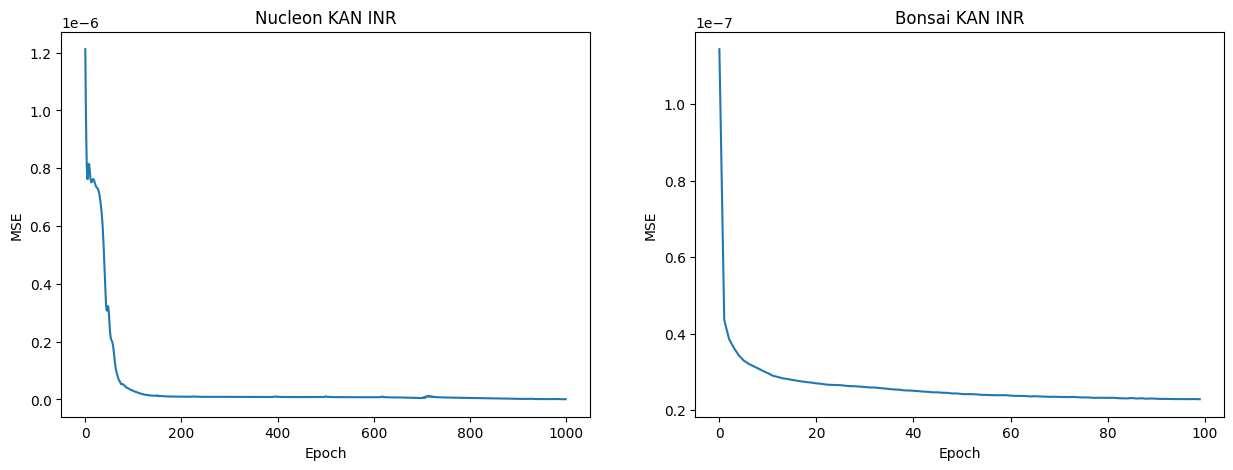

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

nucleon_data = pd.read_csv("nucleon_output.csv")
bonsai_data = pd.read_csv("bonsai_output.csv")

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(nucleon_data["epoch"], nucleon_data["avg_loss"])
ax1.set_title("Nucleon KAN INR")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")

ax2.set_title("Bonsai KAN INR")
ax2.plot(bonsai_data["epoch"], bonsai_data["avg_loss"])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE")
figure.show()

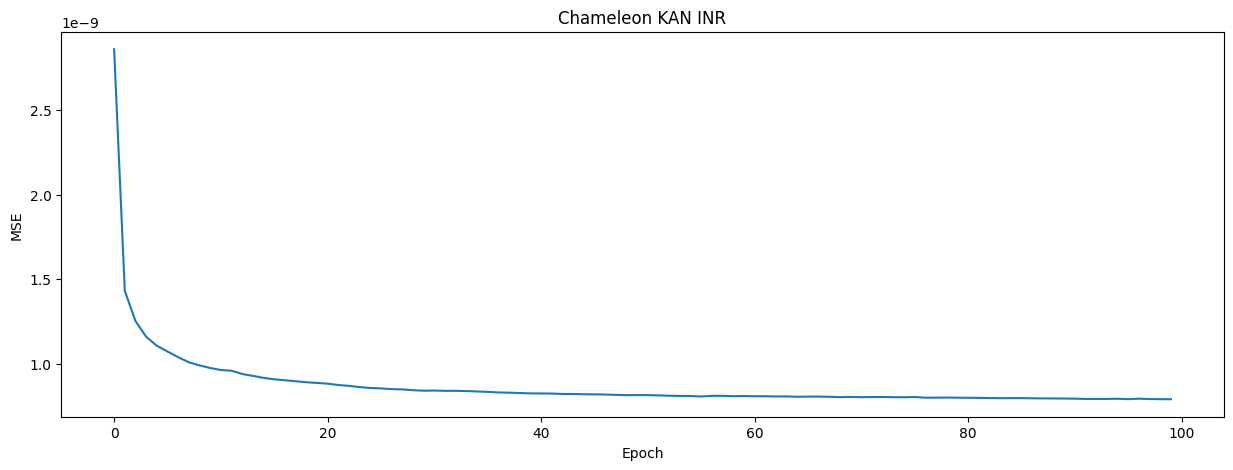

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

chameleon_data = pd.read_csv("chameleon_output.csv")
figure, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(chameleon_data["epoch"], chameleon_data["avg_loss"])
ax.set_title("Chameleon KAN INR")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
figure.show()

In [2]:
# Concatenate all .csv result files into one dataframe
from pathlib import Path
import pandas as pd


csv_files = list(Path("/grand/insitu/cohanlon/results").glob("*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Filter on dataset "beechnut"
beechnut_results = combined_df[combined_df["dataset"] == "beechnut"]

# Order results by model then log2_hashmap_size
beechnut_results = beechnut_results.sort_values(["model", "log2_hashmap_size"])

beechnut_results

/tmp/ipykernel_2320123/2896039664.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(df_list, ignore_index=True)


,model,dataset,log2_hashmap_size,compression_ratio,psnr,ssim,mse
8,kan,beechnut,9,148998.023529,39.270377,0.000118,0.916023
13,kan,beechnut,10,75837.317365,40.406666,0.000091,0.931750
14,kan,beechnut,10,40633.617726,40.220092,0.000095,0.929095
15,kan,beechnut,11,23783.722066,40.865166,0.000082,0.938406
7,kan,beechnut,13,6075.716959,41.883641,0.000065,0.951030
1,kan,beechnut,14,3117.497108,41.541030,0.000070,0.947161
12,kan,beechnut,15,1607.110209,42.896812,0.000051,0.961119
2,kan,beechnut,16,779.254392,43.144433,0.000048,0.963556
9,kan,beechnut,17,394.918287,43.401747,0.000046,0.965534
16,mlp,beechnut,9,219809.965559,38.404797,0.000144,0.897949


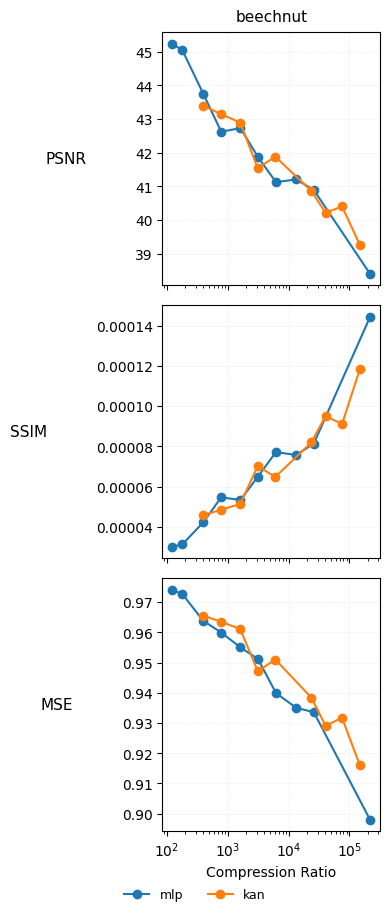

In [6]:
# %% [markdown]
# ## Compression‑Ratio Curves (models overlayed)
# Grid layout → **rows = metrics (PSNR, SSIM, MSE)**, **columns = datasets**.
# Every subplot shows *all* models for that dataset in different colors.
# Dataset names sit above columns, metric names on the left.
# A single legend (model ↔ color) appears beneath the entire grid.

# %%
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------- CONFIG -----------------
CSV_PATH = "result.csv"  # ← Update path if needed
METRICS = ["psnr", "ssim", "mse"]  # Row order
COLOR_CYCLE = plt.rcParams["axes.prop_cycle"].by_key()["color"]
LINE_KW = dict(marker="o", linewidth=1.5)
LEGEND_FONTSIZE = 9

# --------------- LOAD DATA ---------------
# df = pd.read_csv(CSV_PATH)
df = beechnut_results
df = df.sort_values("compression_ratio", ascending=True)

datasets = df["dataset"].unique()
models = df["model"].unique()

n_rows, n_cols = len(METRICS), len(datasets)
fig, axes = plt.subplots(
    n_rows, n_cols, sharex="col", figsize=(4 * max(1, n_cols), 3 * max(1, n_rows))
)

# ---- ensure axes is a true 2‑D array matching (rows, cols) ----
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:  # one metric, many datasets => shape (1, n_cols)
    axes = axes[np.newaxis, :]
elif n_cols == 1:  # many metrics, one dataset => shape (n_rows, 1)
    axes = axes[:, np.newaxis]

# ---------------- PLOT GRID ----------------
for c, ds in enumerate(datasets):
    dset_df = df[df["dataset"] == ds]
    for r, metric in enumerate(METRICS):
        ax = axes[r, c]
        for m_ix, model in enumerate(models):
            mdf = dset_df[dset_df["model"] == model]
            if mdf.empty:
                continue  # model not present in this dataset
            color = COLOR_CYCLE[m_ix % len(COLOR_CYCLE)]
            ax.plot(
                mdf["compression_ratio"],
                mdf[metric],
                label=model,
                color=color,
                **LINE_KW
            )
        ax.set_xscale("log")

        # Column & row titles / labels
        if r == 0:
            ax.set_title(ds, fontsize=11, pad=8)
        if c == 0:
            ax.set_ylabel(
                metric.upper(),
                rotation=0,
                ha="right",
                va="center",
                labelpad=35,
                fontsize=11,
            )
        if r == n_rows - 1:
            ax.set_xlabel("Compression Ratio")

        ax.grid(True, linestyle=":", linewidth=0.4, alpha=0.5)

# ---------------- GLOBAL LEGEND ----------------
# Collect unique handles/labels (models) from all axes
handles, labels = [], []
seen = set()
for ax in fig.axes:
    for line in ax.get_lines():
        lbl = line.get_label()
        if lbl not in seen and not lbl.startswith("_line"):
            handles.append(line)
            labels.append(lbl)
            seen.add(lbl)
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(labels),
    fontsize=LEGEND_FONTSIZE,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02),
)

fig.tight_layout()
plt.show()